In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field
import json

from sys import path

path.append("../src/")
from prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from utils import format_messages
from tools.others import get_today_str

# graph state

class ResearchAgentState(MessagesState):
    is_topic_clarified: bool


# structured output schemas

class ResearchQuestion(BaseModel):
    title: str

class ResearchTopicAnalysis(BaseModel):
    is_topic_clarified: bool = Field(
        description="Whether the user needs to be asked for a clarification on the topic."
    )
    question: str = Field(
        description="A question to ask the user to clarify the topic research."
    )


model = init_chat_model(model="gpt-4o-mini", temperature=0)

def analyze_research_topic(state):

    structured_output_model = model.with_structured_output(ResearchTopicAnalysis)
    response = structured_output_model.invoke(
        input=[
            HumanMessage(content=clarify_with_user_instructions.format(
                messages=get_buffer_string(state.get("messages")),
                date=get_today_str()
            ))
        ]
    )
    ai_message = AIMessage(content=json.dumps(response.model_dump()))
    is_topic_clarified = response.is_topic_clarified

    return {"messages": [ai_message], "is_topic_clarified": is_topic_clarified}

def write_research_brief(state):

    structured_output_model = model.with_structured_output(ResearchQuestion)
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    ai_message = AIMessage(content=json.dumps(response.model_dump()))

    return {"messages": [ai_message]}


def check_clarity(state):

    direction = "write_research_brief" if state.get("is_topic_clarified") else END

    return direction


graph = StateGraph(ResearchAgentState)

graph.add_node("analyze_research_topic", analyze_research_topic)
graph.add_node("write_research_brief", write_research_brief)
#graph.add_node("check_clarity", check_clarity)

graph.add_edge(START, "analyze_research_topic")
graph.add_conditional_edges("analyze_research_topic", check_clarity, {"write_research_brief": "write_research_brief", END: END})
graph.add_edge("write_research_brief", END)

In [ ]:
app = graph.compile()#(checkpointer=checkpointer)
result = app.invoke(
    {"messages": [
        HumanMessage(content="I want to research the best coffee shops")
    ]}
)

In [3]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ {"is_topic_clarified": false, "question": "What specific criteria are you looking for in the best coffee shops? │
│ (e.g., location, ambiance, menu variety, customer reviews)"}                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

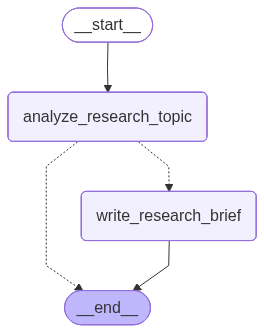

In [ ]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))